In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%load_ext Cython
%load_ext line_profiler

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
class particleClass():
    nMade=0
    def __init__(self,whichGal):
        self.pos=np.zeros(3)
        self.vel=np.zeros(3)
        self.m=0
        self.index=particleClass.nMade
        self.galaxy=whichGal
        particleClass.nMade+=1

In [33]:
%%cython -a -f --compile-args=-DCYTHON_TRACE=1
import numpy as np
cimport numpy as np

cpdef findAcc(particles,thisParticle,double boxSize):
    cdef np.ndarray pos=thisParticle.pos
    cdef int index=thisParticle.index
    cdef np.ndarray acc, e_r
    for p in particles:
        e_r=(pos-p.pos) #vector from loop particle to this particle

        for i in range(3): #checks periodic boundary conditions
            if (e_r[i] > boxSize/2):
                e_r[i]-=boxSize
            elif (e_r[i] < -boxSize/2):
                e_r[i]+=boxSize
        r=np.linalg.norm(e_r)+0.1 #0.1 is gravitational softening length
        e_r=e_r/r # normalises to make into unit vector

        if (p.index == index): # the particle should feel no force from itself
            continue
        acc+=(-p.m/(r**2))*e_r # == GM/r^3 _r_ in units where G=1
    return acc

In [15]:
def runSim(particles,boxSize,dt,endTime,nPlots): #simple leapfrog integration
    nTimestep=int(endTime/dt)
    for i in range(nTimestep):
        for p in particles: #to do leapfrog integration need to update all positions
            p.pos=(p.pos+dt*p.vel) % boxSize
        for p in particles: #then compute new accelerations on this evolved systems
            acc=findAcc(particles,p,boxSize)
            p.vel=p.vel+dt*acc
        if (i%int(nTimestep/nPlots)==0):
            plotSim(particles,i*dt,i/int(nTimestep/nPlots))

def initSim(nGal,nParticles,boxSize):
    scale=5 #scale radius of disk
    pMass=1 #mass of each particle
    coreMass=1000 #mass of galaxy core
    particleClass.nMade=0
    particles=[]
    for whichGal in range(nGal):
        galPos=boxSize*np.random.random(3)
        galVel=(boxSize/100)*(1-2*np.random.random(3))
        
        print('galPos: ',galPos)
        print('galVel: ',galVel)
    
        galSpin=(1-2*np.random.random(3))
        galSpin=galSpin/np.linalg.norm(galSpin)
        
        #adds central, massive galaxy particle
        newP=particleClass(whichGal)
        newP.pos=galPos
        newP.vel=galVel
        newP.m=coreMass
        newP.gal=whichGal
        particles.append(newP)
        
        for i in range(nParticles):
            newP=particleClass(whichGal)
            rad = 1-scale*np.log(1-np.random.random()) #  drawn from distribution prop to e^(-(r/5))
            randDirn = 0.1-2*np.random.random(3) # finds a random vector in plane of disk (plus grav softening length)
            diskDirn = np.cross(galSpin,randDirn) 
            diskDirn = diskDirn/np.linalg.norm(diskDirn)
            newP.pos=(galPos+diskDirn*rad) % boxSize
            circVel=np.sqrt(coreMass/rad)
            newP.vel=galVel+circVel*np.cross(diskDirn,galSpin)
            newP.m=pMass
            newP.gal=whichGal
            particles.append(newP)
    return particles

def plotSim(particles,time,whichPlot):
    fig=plt.subplot(grid[int(whichPlot),0])
    fig.set_xlim(0,boxSize)
    fig.set_ylim(0,boxSize)
    fig.set_xlabel("x")
    fig.set_ylabel("y")
    fig.set_title('t='+str(time))
    for p in particles:
        fig.scatter(p.pos[0],p.pos[1],color=cmap(p.galaxy/nGal),s=np.sqrt(p.m)/2)
        #fig.quiver(p.pos[0],p.pos[1],p.vel[0],p.vel[1])

galPos:  [  86.70983644  143.81991138   54.81402949]
galVel:  [-0.2468942  -1.79982307 -1.85495283]
galPos:  [  81.11040378  153.68659174  109.49209559]
galVel:  [-1.54962875  1.44671694  1.91937126]


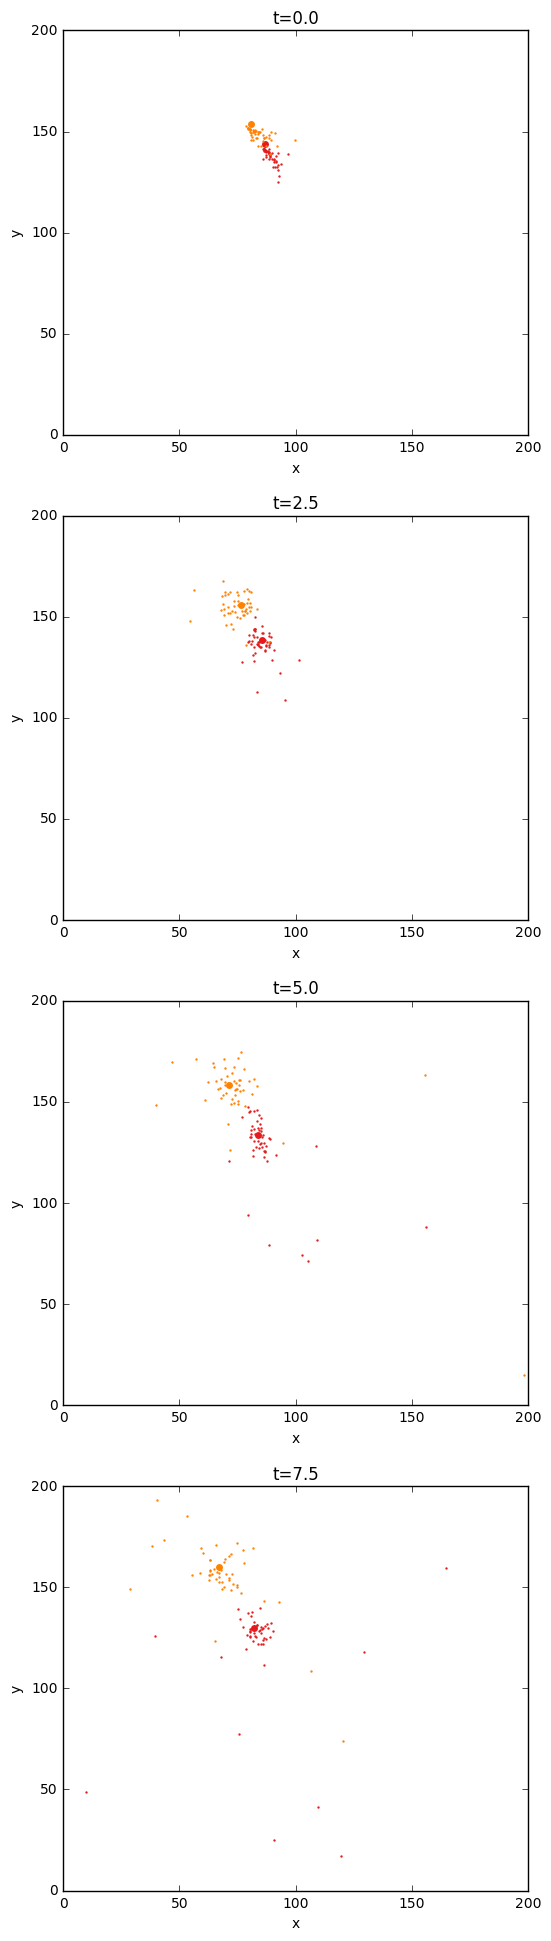

In [25]:
nParticles=50
nGal=2
boxSize=200 # not periodic!
dt=0.1 # in units where G=1
endTime=10
#in these units it takes roughly t=80 for two particles of mass 1 
#to cross corner to corner of boxSize=10 and come to rest

nPlots=4
plots=plt.figure(figsize=(6,nPlots*6))
grid=matplotlib.gridspec.GridSpec(nPlots,1)
cmap=matplotlib.cm.get_cmap('Set1')

particles=initSim(nGal,nParticles,boxSize)
%lprun -f runSim runSim(particles,boxSize,dt,endTime,nPlots)

plt.show()